<a href="https://colab.research.google.com/github/esrayuzgec/AlzheimerTesting/blob/main/oas_vit_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastai.vision.all import *

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import timm 

In [ ]:
path = Path('/content/gdrive/MyDrive/OASIS/Train')

In [ ]:
path.ls()

(#6) [Path('/content/gdrive/MyDrive/OASIS/Train/MILD'),Path('/content/gdrive/MyDrive/OASIS/Train/CNMILD_ResNet50_Train.pth'),Path('/content/gdrive/MyDrive/OASIS/Train/Binary_ResNet50TrainExp.pkl'),Path('/content/gdrive/MyDrive/OASIS/Train/CN'),Path('/content/gdrive/MyDrive/OASIS/Train/CNMILD_ResNet50_Train2.pth'),Path('/content/gdrive/MyDrive/OASIS/Train/Binary_ResNet50TrainExp2.pkl')]

In [ ]:
item_tfms= Resize(224)

In [ ]:
brain = DataBlock(blocks=(ImageBlock,CategoryBlock),
                  get_items= get_image_files,
                  get_y = parent_label,
                  splitter =RandomSplitter(valid_pct= 0.4),
                  item_tfms = item_tfms
                
                  )

In [ ]:
dls=brain.dataloaders(path, bs=16)

In [ ]:
timm.list_models('vit*')

['vit_base_patch8_224',
 'vit_base_patch8_224_dino',
 'vit_base_patch8_224_in21k',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_dino',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_224_sam',
 'vit_base_patch16_384',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_rpn_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_clip_laion2b',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_224_sam',
 'vit_base_patch32_384',
 'vit_base_patch32_plus_256',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_giant_patch14_224',
 'vit_giant_patch14_224_clip_laion2b',
 'vit_gigantic_patch14_224',
 'vit_huge_patch14_224',
 'vit_huge_patch14_224_clip_laion2b',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch14_224',
 'vit_large_

In [ ]:
learn= vision_learner(dls,'vit_small_resnet50d_s16_224',metrics=accuracy)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth" to /root/.cache/torch/hub/checkpoints/resnet50d_ra2-464e36ba.pth


SuggestedLRs(valley=0.0006918309954926372)

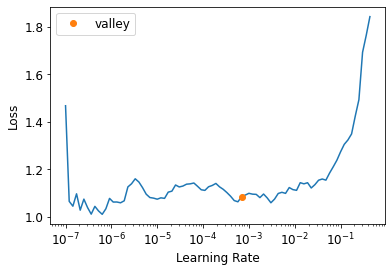

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(100,1.1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.798460,0.406952,0.831720,00:45


epoch,train_loss,valid_loss,accuracy,time
0,0.563241,0.353865,0.847312,00:28
1,0.572038,0.296250,0.878495,00:27
2,0.488974,0.285113,0.872043,00:27
3,0.463101,0.268308,0.889785,00:27
4,0.411470,0.228009,0.908065,00:27
5,0.381994,0.213526,0.916129,00:27
6,0.354039,0.232082,0.906452,00:27
7,0.312971,0.207877,0.919355,00:27
8,0.326795,0.189368,0.923118,00:27
9,0.292443,0.167601,0.938172,00:27


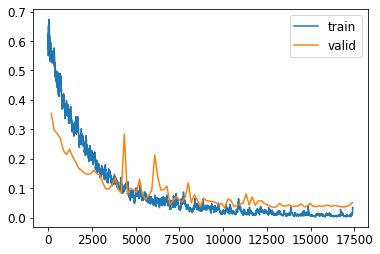

In [ ]:
learn.recorder.plot_loss()

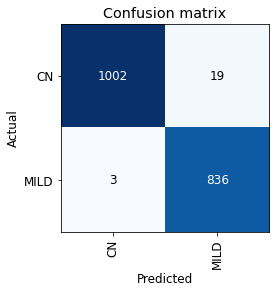

In [32]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [33]:
learn.save(path/'oas_vit')

Path('/content/gdrive/MyDrive/OASIS/Train/oas_vit.pth')

In [34]:
learn.export(path/'oas_vit.pkl')

In [35]:
interp.print_classification_report()

              precision    recall  f1-score   support

          CN       1.00      0.98      0.99      1021
        MILD       0.98      1.00      0.99       839

    accuracy                           0.99      1860
   macro avg       0.99      0.99      0.99      1860
weighted avg       0.99      0.99      0.99      1860



In [37]:
losses,idxs = interp.top_losses(22)
print(idxs)

TensorBase([ 351,  382, 1544, 1414,  409,  102,  276,  925, 1378,  761, 1217,  575, 1577,   85,  730, 1230,  452, 1258,  658, 1308, 1781,  528])


In [47]:
dls.valid_ds.items[409]

Path('/content/gdrive/MyDrive/OASIS/Train/MILD/mild_12.png')

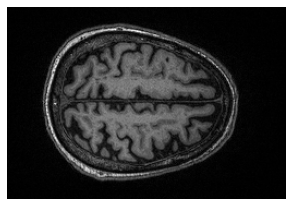

In [48]:
img = PILImage.create('/content/gdrive/MyDrive/OASIS/Train/MILD/mild_12.png')
img.show()

In [49]:
learn.predict(img)

('CN', tensor(0), tensor([0.9972, 0.0028]))

In [96]:
path = Path('/content/gdrive/MyDrive/OASIS')

In [97]:
all_files= get_image_files(path)

In [103]:
dblock=DataBlock(blocks=(ImageBlock(cls=PILImage),CategoryBlock),
                 splitter=GrandparentSplitter(train_name='Train', valid_name='Test'),
                 get_y=parent_label,
                 item_tfms=Resize(224,method='squish'),
                 batch_tfms=Normalize.from_stats(*imagenet_stats)
                 
                 
)

In [104]:
dls_test = dblock.dataloaders(all_files)

In [105]:
print("Number of examples in testing:", len(dls_test.valid_ds))

Number of examples in testing: 650


In [106]:
learn1 = vision_learner(dls_test, 'vit_small_resnet50d_s16_224', metrics=accuracy).load('/content/gdrive/MyDrive/OASIS/Train/oas_vit')

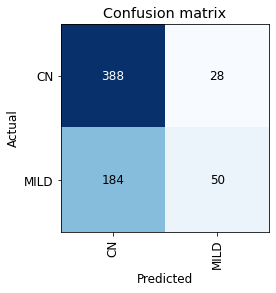

In [107]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()

In [111]:
preds, targs = learn1.tta()
accuracy(preds, targs).item()

0.6738461256027222